In [106]:
import pandas as pd
import numpy as np
from nptdms import TdmsFile
from pathlib import Path
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import re

tdms_dir = r'C:\Users\patry\Desktop\studia\engineering_thesis\dane_temp'

tdms_list = []

for root, dirs, files in os.walk(tdms_dir):
    print(f"There are {len(dirs)} directories and {len(files)} file in {root}")
    
    for file in files:
        if file.endswith(".tdms"):
            tdms_list.append(os.path.join(root, file))

pattern = r'ziemowit_(\d)'
data_list = []

for tdms_file_path in tdms_list:
    tdms_file = TdmsFile.read(tdms_file_path)
    
    filename = os.path.basename(tdms_file_path)
    label_match = re.findall(pattern, filename)
    label = label_match[0] if label_match else None 


    if label:
        for group in tdms_file.groups():
            for channel in group.channels():
                data_len = len(channel.data)
                
                if 1000 <= data_len <= 100000000 and channel.name == 'Voltage':
                    data_list.append({
                        'excitation': channel.data,
                        'id': label
                    })

df_magnitude = pd.DataFrame(data_list)
df_magnitude.head()

There are 0 directories and 24 file in C:\Users\patry\Desktop\studia\engineering_thesis\dane_temp


,excitation,id
0,"[3.82823444, -3.701467284, -4.374274544, -4.38...",2
1,"[8.46135742, 10.465749096, 10.465749096, 5.192...",2
2,"[-4.330589902, -4.3366483559999995, -4.3385615...",2
3,"[10.465749096, 10.465749096, 10.465749096, 10....",3
4,"[-0.43819263999999997, 9.452074082000001, 10.4...",3


In [107]:
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs  # Częstotliwość Nyquista
    low = lowcut / nyquist
    high = highcut / nyquist
    
    # Projektowanie filtra
    b, a = butter(order, [low, high], btype='band')
    # Filtrowanie sygnału
    y = lfilter(b, a, data)
    return y

df_magnitude['excitation'] = df_magnitude['excitation'].apply(lambda x: bandpass_filter(x, 3000, 8000, 50000))

df_magnitude['type_id'] = df_magnitude['id'].apply(lambda x: 1 if int(x) == 4 else 0)

df_magnitude

,excitation,id,type_id
0,"[0.004910021058569663, 0.02697823897075677, 0....",2,0
1,"[0.010852376929215618, 0.08354485445409147, 0....",2,0
2,"[-0.0055543326690434165, -0.041450937020197295...",2,0
3,"[0.013423171767679517, 0.1001558200600991, 0.3...",3,0
4,"[-0.000562017589003832, 0.008491623964885358, ...",3,0
5,"[-0.01142470955598437, -0.0814201768839481, -0...",3,0
6,"[0.013423171767679517, 0.1001558200600991, 0.3...",4,1
7,"[0.006901712255406951, 0.056831554489023474, 0...",4,1
8,"[0.013423171767679517, 0.09769340266869103, 0....",4,1


In [108]:
df_magnitude['len'] = df_magnitude['excitation'].apply(lambda x: len(x))

def trim_to_min_length(group):
    min_len = group['len'].min()  
    group['excitation'] = group['excitation'].apply(lambda x: x[:min_len]) 
    return group

df_magnitude = df_magnitude.groupby('id').apply(trim_to_min_length)

df_magnitude['len'] = df_magnitude['excitation'].apply(lambda x: len(x))

df_magnitude = df_magnitude.droplevel(level=0)

df_magnitude.drop(columns=['len'], inplace=True)

df_magnitude['time'] = df_magnitude['excitation'].apply(lambda x: len(x) / 50000)

df_magnitude

,excitation,id,type_id,time
0,"[0.004910021058569663, 0.02697823897075677, 0....",2,0,6.0
1,"[0.010852376929215618, 0.08354485445409147, 0....",2,0,6.0
2,"[-0.0055543326690434165, -0.041450937020197295...",2,0,6.0
3,"[0.013423171767679517, 0.1001558200600991, 0.3...",3,0,15.0
4,"[-0.000562017589003832, 0.008491623964885358, ...",3,0,15.0
5,"[-0.01142470955598437, -0.0814201768839481, -0...",3,0,15.0
6,"[0.013423171767679517, 0.1001558200600991, 0.3...",4,1,10.0
7,"[0.006901712255406951, 0.056831554489023474, 0...",4,1,10.0
8,"[0.013423171767679517, 0.09769340266869103, 0....",4,1,10.0


In [109]:
def slice_into_chunks(lst, num_chunks):
    return [lst[i * 50000:(i + 1) * 50000] for i in range(int(num_chunks))]

df_magnitude['excitation'] = df_magnitude.apply(lambda row: slice_into_chunks(row['excitation'], row['time']), axis=1)

df_magnitude['id'] = pd.factorize(df_magnitude['id'])[0]

In [110]:
df_magnitude = df_magnitude.groupby(by='id').agg({
    'excitation': lambda x: x.tolist(),
    'type_id': 'first',
    'time': 'first'
}).reset_index()

df_magnitude

,id,excitation,type_id,time
0,0,"[[[0.004910021058569663, 0.02697823897075677, ...",0,6.0
1,1,"[[[0.013423171767679517, 0.1001558200600991, 0...",0,15.0
2,2,"[[[0.013423171767679517, 0.1001558200600991, 0...",1,10.0


In [111]:
import numpy as np
from joblib import load

# Załaduj obiekt StandardScaler zapisany w formacie joblib
scaler = load('scaler.pkl')

magnitude = []
name = []
for idx, row in df_magnitude.iterrows():
    lasty_name = row['type_id']
    for segment in row['excitation']:
        for s in segment:
            magnitude.append(s)
            name.append(lasty_name)

print(np.array(magnitude).shape)

#df_magnitude['excitation'] = scaler.transform(magnitude)

(93, 50000)


In [112]:
import joblib

sc = joblib.load('scaler.pkl')

magnitude = []
name = []
ids = []
for idx, row in df_magnitude.iterrows():
    lasty_name = row['type_id']
    identificator = row['id']
    segment = np.array(row['excitation']).transpose(1, 0, 2)
    for subsegment in segment:
        magnitude.append(sc.transform(subsegment))
        name.append(lasty_name)
        ids.append(identificator)

df_expanded = pd.DataFrame({'name': name, 'signal_segment': magnitude, 'id': ids})

name                                                              1
signal_segment    [[0.6290746641396815, 0.126964024334619, -0.24...
id                                                                2
Name: 30, dtype: object


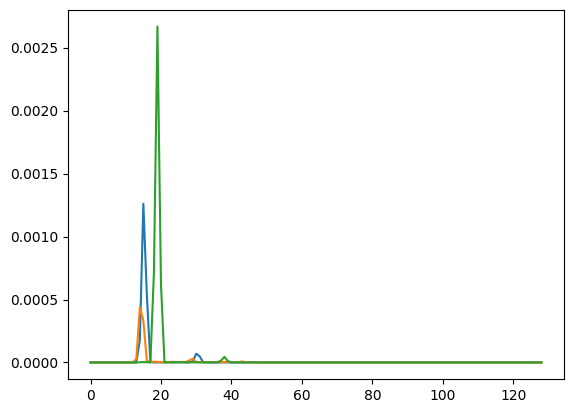

In [113]:
from scipy.signal import welch

sigs = df_expanded.loc[30]

print(sigs)
for s in sigs['signal_segment']:
    plt.plot(welch(s, fs=50000)[1])

In [114]:
from scipy.signal import stft
from PIL import Image

def calculate_stft(signal):
    _, _, Zxx = stft(signal, fs=50000, nperseg=256, noverlap=128)
    # Skalowanie wartości Zxx do zakresu 0-255
    Zxx_abs = np.abs(Zxx)
    Zxx_abs = np.log1p(Zxx_abs)  # Logarytmowanie może pomóc w poprawie kontrastu
    Zxx_scaled = np.uint8(255 * Zxx_abs / np.max(Zxx_abs))  # Skala do 0-255
    
    Zxx_scaled =  Image.fromarray(Zxx_scaled).convert('1').convert('L')

    return np.array(Zxx_scaled)

df_expanded['stft'] = df_expanded['signal_segment'].apply(lambda x: [calculate_stft(s) for s in x])

(-0.5, 391.5, 128.5, -0.5)

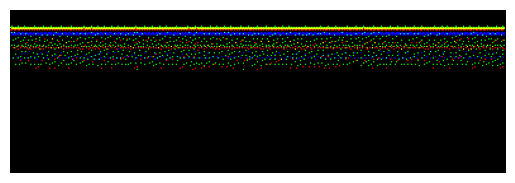

In [115]:
plt.imshow(np.array(df_expanded['stft'][30]).transpose(1, 2, 0))
plt.axis('off')

In [116]:
from transformers import ViTImageProcessor
from sklearn.model_selection import train_test_split
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image

train_df, test_df = train_test_split(df_expanded, random_state=42, test_size=0.2)

class stft_img_dataset(Dataset):
    def __init__(self, df, processor, transform=None):
        self.df = df
        self.processor = processor
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Wczytywanie obrazu i etykiety
        image = np.array(self.df.loc[idx]['stft'])
        label = self.df.loc[idx]['name']

        # If image values are already in [0, 1], set do_rescale=False
        image = image.astype(np.float32)

        # Przetwarzanie obrazu za pomocą procesora
        image = self.processor(image, return_tensors='pt').pixel_values  # Avoid rescaling

        # Jeśli transformacje zostały zdefiniowane, stosujemy je
        if self.transform:
            image = self.transform(image)

        return image, label


    
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
train_dataset = stft_img_dataset(train_df.reset_index(), processor)
test_dataset = stft_img_dataset(test_df.reset_index(), processor)

BATCH_SIZE = 8
train_dataloader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, BATCH_SIZE, shuffle=True)

In [117]:
from transformers import ViTForImageClassification, ViTConfig
import torch
import torch.nn as nn

# Initialize the configuration and set the number of input channels
configuration = ViTConfig.from_pretrained("google/vit-base-patch16-224")
configuration.num_channels = 3

# Load the pretrained model
model = ViTForImageClassification(configuration)

# Move the model to the appropriate device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print()

In [118]:
import torch.nn.functional as F

def align_predictions(image, model, label):

    # Preprocess and predict
    image = np.array(image)
    inputs = processor(image, return_tensors='pt').pixel_values.to(device)
    
    with torch.no_grad():
        outputs = model(pixel_values=inputs)
    
    logits = outputs.logits
    label_tensor = torch.tensor([label], dtype=torch.long).to(device)
    loss = F.cross_entropy(logits, label_tensor).cpu().item()  # Convert loss to a CPU scalar
    
    pred = torch.argmax(logits, axis=1).cpu().item()  # Move logits to CPU and extract the prediction

    return pred, loss


state_dict = torch.load(r'C:\Users\patry\Desktop\NN_and_ML\Anchors\test.pth')

model.load_state_dict(state_dict)
model.to(device)

print()

In [119]:
df_expanded[['pred', 'loss']] = df_expanded.apply(
    lambda row: pd.Series(align_predictions(row['stft'], model, row['name'])), axis=1
)

df_expanded = df_expanded.sort_values(by='loss', ascending=False)

df_expanded.head(10)

,name,signal_segment,id,stft,pred,loss
10,0,"[[1.2033119542052315, 1.2264934789868627, 1.05...",1,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0.0,0.397406
11,0,"[[-1.3863654450406366, -1.7639097189342874, -1...",1,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0.0,0.384569
14,0,"[[1.1252610578114706, 1.3902519677802203, 1.38...",1,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0.0,0.375746
12,0,"[[0.022521307619944628, -0.7976650307258575, -...",1,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0.0,0.369103
13,0,"[[-1.5716227584497238, -1.7034819350581336, -1...",1,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0.0,0.356633
15,0,"[[-1.4672589629559423, -1.1283364892717362, -0...",1,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0.0,0.349378
20,0,"[[-1.4411593281086845, -1.8126707557575725, -1...",1,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0.0,0.343332
16,0,"[[-1.696935420463695, -1.0062017882414558, -0....",1,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0.0,0.326008
7,0,"[[1.1616341423386047, 0.6929866682506013, 0.05...",1,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0.0,0.315076
18,0,"[[-0.519459345357879, 0.37075208808052085, 1.0...",1,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0.0,0.307448


In [120]:
df_expanded = df_expanded.rename(columns={'name': 'label'})

cols = list(df_expanded.columns)  # Lista kolumn
cols.insert(cols.index('pred'), cols.pop(cols.index('label')))  # Przesuwanie kolumny
df_expanded = df_expanded[cols]
df_expanded


,signal_segment,id,stft,pred,label,loss
10,"[[1.2033119542052315, 1.2264934789868627, 1.05...",1,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0.0,0,0.397406
11,"[[-1.3863654450406366, -1.7639097189342874, -1...",1,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0.0,0,0.384569
14,"[[1.1252610578114706, 1.3902519677802203, 1.38...",1,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0.0,0,0.375746
12,"[[0.022521307619944628, -0.7976650307258575, -...",1,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0.0,0,0.369103
13,"[[-1.5716227584497238, -1.7034819350581336, -1...",1,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0.0,0,0.356633
15,"[[-1.4672589629559423, -1.1283364892717362, -0...",1,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0.0,0,0.349378
20,"[[-1.4411593281086845, -1.8126707557575725, -1...",1,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0.0,0,0.343332
16,"[[-1.696935420463695, -1.0062017882414558, -0....",1,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0.0,0,0.326008
7,"[[1.1616341423386047, 0.6929866682506013, 0.05...",1,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0.0,0,0.315076
18,"[[-0.519459345357879, 0.37075208808052085, 1.0...",1,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0.0,0,0.307448


In [121]:
acc = df_expanded['label'] == df_expanded['pred']

acc.value_counts(True)

True    1.0
Name: proportion, dtype: float64

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

def plot_confusion_matrix(y_true, y_pred, class_names=None, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred, normalize='true')  # Normalizacja w celu uzyskania proporcji
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    
    plt.figure(figsize=(8, 6))
    disp.plot(cmap='Blues', values_format=".2f", ax=plt.gca())  # Wyświetlenie na obecnym subplotcie
    plt.title(title)
    plt.show()


def plot_roc_curve(y_true, y_scores, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

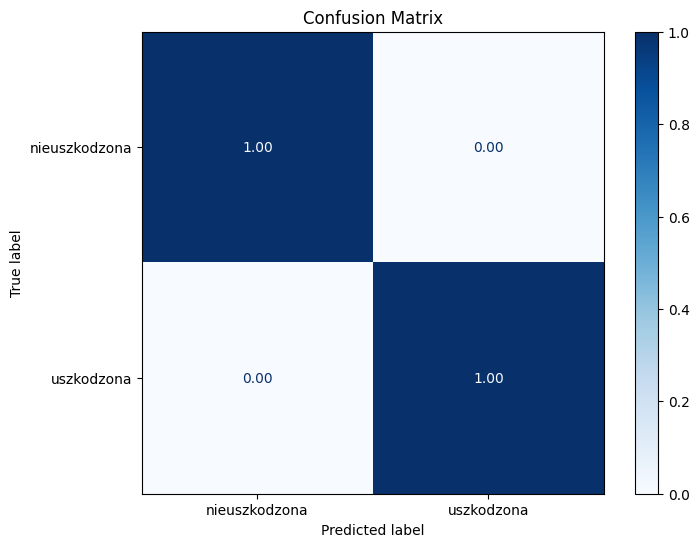

In [123]:
y_true = np.array(df_expanded['label'])
y_pred = np.array(df_expanded['pred'])
classes = {'nieuszkodzona': 1, 'uszkodzona': 0}

plot_confusion_matrix(y_true, y_pred, classes)

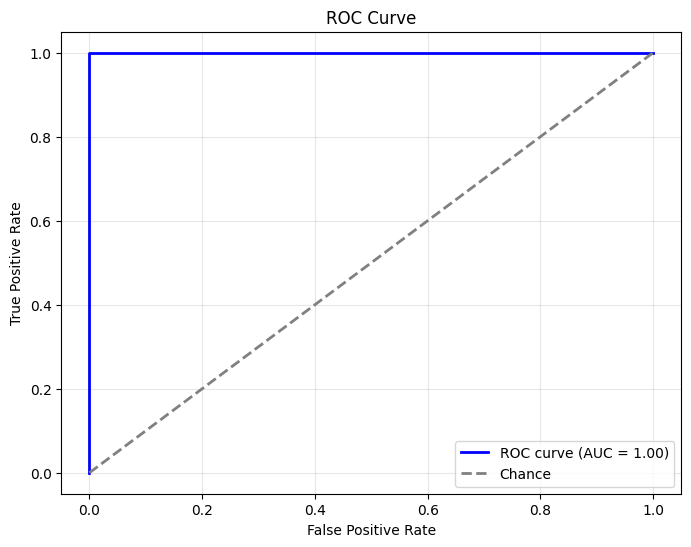

In [124]:
plot_roc_curve(y_true, y_pred)

In [125]:
df = df_expanded[df_expanded['loss'] > 1]

fig, axs = plt.subplots(len(df)//2, 2,  figsize=(15, 10))
axs = axs.flatten()

for ax, (idx, row) in zip(axs, df.iterrows()):
    stft = row['stft']
    ax.imshow(np.array(stft).transpose(1, 2, 0))
    ax.set_title(f'pred: {int(row["pred"])}, label: {int(row["label"])}, loss: {round(row["loss"], 2)}, ids {row["id"]}')
    ax.axis('off')

ValueError: Number of rows must be a positive integer, not 0

<Figure size 1500x1000 with 0 Axes>

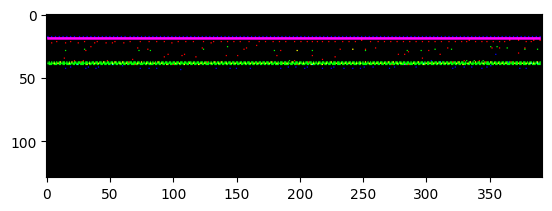

In [105]:
# Sprawdź, czy dane są w Tensorze
stft_data = np.array(df_expanded[df_expanded['id'] == 0].loc[0]['stft'])

# Jeśli dane nie są w Tensorze, przekształć je na Tensor
stft_tensor = torch.tensor(stft_data)

# Jeśli chcesz zmienić kolejność wymiarów (permute) na Tensorze
stft_tensor = stft_tensor.permute(1, 2, 0)

# Przekształć Tensor z powrotem na ndarray przed użyciem plt.imshow
stft_array = stft_tensor.numpy()

# Wyświetl obraz
plt.imshow(stft_array)
plt.show()